# CMS GIWAXS mask & .poni generation notebook

In [1]:
# Kernel updates if needed, remember to restart the kernel after running this cell!:
!pip install -e /nsls2/users/kwhite1/github_repositories/PyHyperScattering

Obtaining file:///nsls2/users/kwhite1/github_repositories/PyHyperScattering
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for PyHyperScattering (pyproject.toml) ... done
  Created wheel for PyHyperScattering: filename=PyHyperScattering-0+untagged.507.g867836f-0.editable-py3-none-any.whl size=5452 sha256=c80ab22d7298a49c7d04d374ebe57609e3dae8b9763887f1887503aac8e192f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-9uttvkpg/wheels/30/84/5c/14c2ecfa0d45346e2aedbd65a4d8a149b1284612774dc76b95
Successfully built PyHyperScattering
  Attempting uninstall: PyHyperScattering
    Found existing installation: PyHyperScattering 0+untagged.507.g867836f
    Uninstalling PyHyperScattering-0+untagged.507.g867836f:
      Successfully uninstalled PyHyperScattering-0+untagged.507.g867836f


## Imports

In [6]:
# Imports:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import PyHyperScattering as phs
import pyFAI
from pyFAI.gui import jupyter
from pyFAI.gui.jupyter.calib import Calibration
import pygix
import fabio

print(f'Using PyHyperScattering Version: {phs.__version__}')
print(f"Using pyFAI version {pyFAI.version}")

# Initialize a giwaxs data loader without any metadata naming scheme
loader = phs.load.CMSGIWAXSLoader()

Using PyHyperScattering Version: 0+untagged.507.g867836f.dirty
Using pyFAI version 2023.5.0


## Define paths & show calibration file

In [4]:
maskponiPath.exists()

False

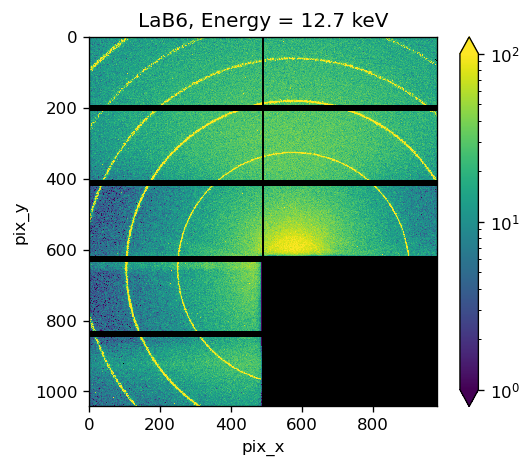

In [3]:
# Replace the paths with the ones relevant to your data, you can use the ".exists()" method to make sure you defined a path correctly
userPath = pathlib.Path('/nsls2/users/kwhite1')  # Your users path is great for small items that are personal to you (100 GB limit)
propPath = pathlib.Path('/nsls2/data/cms/proposals/2023-2/pass-311415')  # The proposals path is a good place to store large data (>1 TB space?)
dataPath = propPath.joinpath('2023C2_KWhite')
maskponiPath = userPath.joinpath('github_repositories/giwaxs_suite/ponimask_kwhite')
calibPath = maskponiPath.joinpath('LaB6_5.6m_12.7keV_corrected_1150.1s_x-1.601_th0.500_5.00s_1116949_maxs.tiff')

# Load calibration file
LaB6_DA = loader.loadSingleImage(calibPath)  # Loads the file specified at calibPath into an xr.DataArray object
energy = 12.7  # keV

# Plot 
cmap = plt.cm.viridis.copy()  # Set a colormap, here I've chosen viridis
cmap.set_bad('black')  # Set the color for the detector gaps
# clim=(6e1, 1e3)  # Specify color limits
clim=(1, 1e2)  # Specify color limits

# Set origin to 'upper' for the reading direction, plot raw data with origin upper.
ax = LaB6_DA.plot.imshow(norm=LogNorm(clim[0], clim[1]), cmap=cmap, figsize=(5,4), origin='upper')
ax.axes.set(aspect='equal', title=f"LaB6, Energy = {energy} keV")
ax.figure.set(dpi=120)
plt.show()

## Draw mask:

In [4]:
# Draw mask
draw = phs.IntegrationUtils.DrawMask(LaB6_DA, clim=clim)
draw.ui()

Usage: click the "PolyAnnotator" tool at top right.  DOUBLE CLICK to start drawing a masked object, SINGLE CLICK to add a vertex, then DOUBLE CLICK to finish.  Click/drag individual vertex to adjust.


:Layout
   .DynamicMap.I :DynamicMap   []
      :Overlay
         .Image.I    :Image   [pix_y,pix_x]   (value)
         .Polygons.I :Polygons   [x,y]   (Label,Value)
   .Annotator.I  :Overlay
      .Table.PolyAnnotator          :Table   [Label]
      .Table.PolyAnnotator_Vertices :Table   [x,y]   (Value)

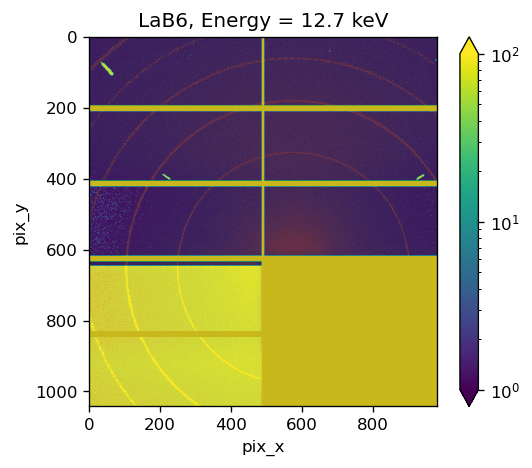

In [18]:
# Save drawn mask above
# draw.save(maskponiPath.joinpath('LaB6.json'))
# draw.load(maskponiPath.joinpath('LaB6.json'))
# mask = draw.mask  # Loads mask as numpy array

mask_edfPath = maskponiPath.joinpath('jun23_nslsii11bmcms_WAXS2pil1M_mask_02.edf')
mask_edf = fabio.open(mask_edfPath).data
# Plot it over calibrant image to check
ax = LaB6_DA.plot.imshow(norm=LogNorm(clim[0], clim[1]), cmap=cmap, figsize=(5,4), origin='upper')
# ax.axes.imshow(mask, alpha=0.5)
ax.axes.imshow(mask_edf, alpha=.8)
ax.axes.set(aspect='equal', title=f"LaB6, Energy = {energy} keV")
ax.figure.set(dpi=120)
plt.show()

## Run pyFAI calibration:

### PyFAI calibration widget

In [ ]:
# Set matplotlib backend to 'widget':
%matplotlib widget

In [ ]:
# Open & run calibration widget
plt.close('all')
LaB6_da = loader.loadSingleImage(calibPath)  # This is needed if you did not execute the above cells for masking
wavelength = np.round((4.1357e-15*2.99792458e8)/(energy*1000), 13)  # Important to be correct! Make sure the energy is in keV and correct!
pilatus = pyFAI.detector_factory('Pilatus1M')
LaB6 = pyFAI.calibrant.CALIBRANT_FACTORY("LaB6")
LaB6.wavelength = wavelength

calib = Calibration(LaB6_da.data, calibrant=LaB6, wavelength=wavelength, detector=pilatus)

### Modifying & saving poni

In [ ]:
### Check & save .poni
gr = calib.geoRef
print(gr)
print(calib.fixed)
print(gr.chi2())
# gr.save(maskponiPath.joinpath('LaB6_unfixed_rot_2023-07-15.poni'))

In [ ]:
# Optional fit with rotations fixed to 0
# Likely the best fit for transmission geometry
gr = calib.geoRef
gr.rot1=gr.rot2=gr.rot3=0
# # gr.center_array=[517, 654.47]
center_x = 517.2
# center_y = 654
gr.poni2 = center_x * gr.pixel1
# gr.poni1 = center_y * gr.pixel1
# gr.set_dist = 2.837
gr.refine3(fix=['wavelength', 'rot1', 'rot2', 'rot3', 'poni2'])
# gr.refine3(fix=['wavelength', 'rot1', 'rot2', 'rot3'])
print(gr.chi2())
print(gr)
gr.save(maskponiPath.joinpath(f'LaB6_fixed_rot_x{center_x}.poni'))

### Calibrant check

In [ ]:
# Turn matplotlib backend back to inline mode & clear open widget plots
%matplotlib inline  
plt.close('all')

# This verifies that the calibration is good (overlays expected calibrant peaks with reduced data)
# azimuthal integrator tool in pyFAI for transmission mode (use pygix for GI geometry)
ai = pyFAI.load(str(maskponiPath.joinpath('LaB6_fixed_rot.poni')))  # Load the .poni calibration file into azimuthal integrator
res1 = ai.integrate1d(LaB6_da.data, 1000)  # Circular integration
res2 = ai.integrate2d(LaB6_da.data, 1000)  # Makes caked 2d image (q vs chi)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set(size_inches=(10,4))
jupyter.plot1d(res1, ax=ax1, calibrant=LaB6)
jupyter.plot2d(res2, ax=ax2, calibrant=LaB6)
ax2.set_title('2D cake')
plt.tight_layout()
plt.show()